In [1]:
# # INSTALL IF NEEDED:

# !pip install emoji optuna

In [2]:
# # CONNECT TO COLAB IF NEEDED:

# from google.colab import drive
# import os

# drive.mount('/content/drive')
# os.chdir('./drive/MyDrive/data/tue_lai')

## Load the data

In [3]:
import pandas as pd
import pickle

data_path = '/home/egor/Desktop/Study Materials/Language and AI/Language-and-AI/lai-data/political_leaning.csv'  # gender / feeling_thinking
data = pd.read_csv(data_path)
data.head()

,auhtor_ID,post,political_leaning
0,t2_7ramzeng,"You can ""buy"" the show and stream it through t...",right
1,t2_7ramzeng,"me want to play Q*bert Holy shit, based Alex J...",right
2,t2_7ramzeng,Shouldn't rely on any external services or per...,right
3,t2_7ramzeng,PR to a specific person. Usually that just mea...,right
4,t2_7ramzeng,This article's intention is clear that they wa...,right


In [4]:
TARGET_COL = 'political_leaning'  # change for other datasets



CLASS_SIZE = data[TARGET_COL].value_counts().min()
# CLASS_SIZE = min(10000, data[TARGET_COL].value_counts().min())
data_samples = []

for val in data[TARGET_COL].unique():
    data_samples.append(data[data[TARGET_COL] == val].sample(CLASS_SIZE, random_state = 42))
data = pd.concat(data_samples)

In [5]:
data.iloc[0,1]

'are Not really. Barely. The video is sped up tho You want to agree to disagree but you also say I don’t understand? I get it, not all parents are right. But most are. Not this again My governments fault? Was there in Maastricht, saw him 🇳🇱🇳🇱 Ehhh… some are underage. Not everything that guides is a guide. Another shitty LPT. This sub is going to shit Love it. Normally I’m not into minimalism but I like this one. Who tf is Humphrey Bogart All a bit boring and generic to be honest. It’s like you got them from those “make a free logo” sites. Elisabeth of where? Would be great if you also gave an argument for that instead of just saying “lol” Feels a bit odd to me. Is this comic sans? Plenty of opinions on here are unpopular. I feel people who say “a truly unpopular one!” just say that to express their own disagreement with an opinion. Not really tho. Not all houses with those windows are doorzonwoningen Doesn’t really explain why other countries don’t have this. They’re also replanting? G

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

INDEPENDENT_COL = 'post'


def label_encode(df, col_name):
    label_encoder = LabelEncoder()
    df[col_name] = label_encoder.fit_transform(df[col_name])
    return df, label_encoder


df, le = label_encode(data, TARGET_COL)
X_train, X_test, y_train, y_test = train_test_split(df[INDEPENDENT_COL], df[TARGET_COL], random_state=42)

## Data Pipelines

In [7]:
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.svm import LinearSVC

import string
import emoji
import numpy as np

nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/egor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/egor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
class StylometryFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        stylometry_features = []
        for text in X:
            # Tokenize sentences and words
            sentences = [word_tokenize(sentence) for sentence in sent_tokenize(text)]
            words = [word for sentence in sentences for word in sentence]

            # Basic stylometry features
            features = {
                'sentence_count': len(sentences),
                'word_count': len(words),
                'avg_sentence_length': len(words) / len(sentences) if len(sentences) > 0 else 0,
                'avg_word_length': sum(len(word) for word in words) / len(words) if len(words) > 0 else 0,
                'num_punctuation': sum(1 for char in text if char in string.punctuation),
                'num_uppercase': sum(1 for char in text if char.isupper()),
                'num_digits': sum(1 for char in text if char.isdigit()),
                'num_emojis': len([char for char in text if char in emoji.EMOJI_DATA])
            }

            stylometry_features.append(features)

        return pd.DataFrame(stylometry_features)

In [9]:
def get_single_pipeline_data(transformer):
    output = dict()
    X_processed = transformer.fit_transform(X_train)
    split = train_test_split(X_processed, y_train, test_size=0.25,random_state=42)
    output['X_train'], output['X_val'], output['y_train'], output['y_val'] = split
    output['X_test'] = transformer.transform(X_test)
    return output

def get_pipeline_data():
    result = dict()

    bow_transformer = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('scaler', StandardScaler(with_mean=False))
    ])
    result['bow'] = get_single_pipeline_data(CountVectorizer(stop_words='english'))

    style_bow_transformer = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(stop_words='english')),
        ('stylometry', StylometryFeatureExtractor())
    ])),
    ('scaler', StandardScaler(with_mean=False))
    ])
    result['style_bow'] = get_single_pipeline_data(style_bow_transformer)

    return result

In [10]:
pipelines_data = get_pipeline_data() # comment out the cell if you have the right pickle file
with open(f'pipelines_data_{TARGET_COL}.pkl', 'wb') as file:
    pickle.dump(pipelines_data, file)

## Utils

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_clf(clf, X, y_true, classes, normalize=True, cmap=plt.cm.Blues):
    y_pred = clf.predict(X)

    print(y_pred.shape, y_true.shape)
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()


In [12]:
import optuna
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import xgboost as xgb
from functools import partial


optuna.logging.set_verbosity(optuna.logging.WARNING)
xgb.set_config(verbosity=1)
SEED = 0


def xgb_objective(trial, data_type, use_gpu=True):
    params = {
        'objective': 'multi:softmax',
        'num_class': len(data[TARGET_COL].unique()),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'n_estimators': trial.suggest_int('n_estimators', 10, 25),
        'n_jobs': -1 if not use_gpu else None,
        'device': "cuda" if use_gpu else None
    }

    print(params['n_estimators'], params['max_depth'])
    model = XGBClassifier(**params, random_state=42)
    model.fit(pipelines_data[data_type]['X_train'], pipelines_data[data_type]['y_train'])
    y_pred = model.predict(pipelines_data[data_type]['X_val'])
    accuracy = accuracy_score(pipelines_data[data_type]['y_val'], y_pred)
    return accuracy


def rf_objective(trial, data_type):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500,),
        'max_depth': trial.suggest_int('max_depth', 2, 10, log=True)
    }

    model = RandomForestClassifier(**params, random_state=42)
    model.fit(pipelines_data[data_type]['X_train'], pipelines_data[data_type]['y_train'])
    y_pred = model.predict(pipelines_data[data_type]['X_val'])
    accuracy = accuracy_score(pipelines_data[data_type]['y_val'], y_pred)
    return accuracy

In [13]:
def rf_finetuning(data_type='bow'):
    partial_objective_rf = partial(rf_objective, data_type=data_type)
    study = optuna.create_study(direction='maximize')
    study.optimize(partial_objective_rf, n_trials=10)

    best_model = RandomForestClassifier(random_state=SEED, **study.best_params)
    best_model.fit(pipelines_data[data_type]['X_train'], pipelines_data[data_type]['y_train'])
    return best_model

def xgb_finetuning(data_type='bow'):
    partial_objective_xgb = partial(xgb_objective, data_type=data_type)
    study = optuna.create_study(direction='maximize')
    study.optimize(partial_objective_xgb, n_trials=10)

    best_model = XGBClassifier(random_state=SEED, **study.best_params)
    best_model.fit(pipelines_data[data_type]['X_train'], pipelines_data[data_type]['y_train'])
    return best_model

## Training & evaluating

### No Style SVM

In [14]:
data_type = 'bow'

In [15]:
clf_base = LinearSVC(max_iter=10 ** 3)
clf_base.fit(pipelines_data[data_type]['X_train'], pipelines_data[data_type]['y_train'])
with open(f'clf_base_{TARGET_COL}.pkl', 'wb') as file:
    pickle.dump(clf_base, file)

/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(10932,) (10932,)
              precision    recall  f1-score   support

           0       0.64      0.65      0.65      3572
           1       0.70      0.69      0.69      3655
           2       0.70      0.70      0.70      3705

    accuracy                           0.68     10932
   macro avg       0.68      0.68      0.68     10932
weighted avg       0.68      0.68      0.68     10932



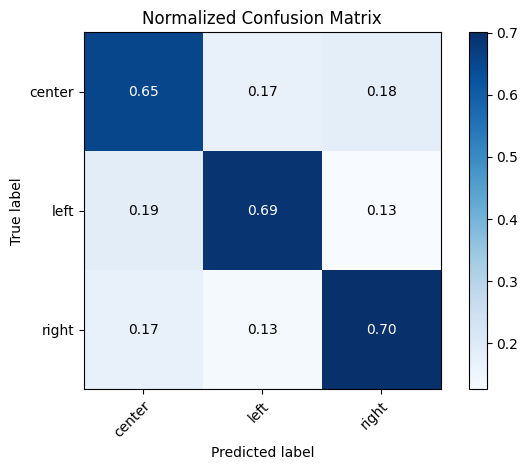

In [16]:
with open(f'clf_base_{TARGET_COL}.pkl', 'rb') as file:
    clf_base = pickle.load(file)
evaluate_clf(clf_base, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)
del clf_base

### No Style RF/XGB

In [17]:
bow_rf = rf_finetuning(data_type)
with open(f'bow_rf_{TARGET_COL}.pkl', 'wb') as file:
    pickle.dump(bow_rf, file)

(10932,) (10932,)
              precision    recall  f1-score   support

           0       0.76      0.15      0.25      3572
           1       0.50      0.66      0.57      3655
           2       0.49      0.70      0.57      3705

    accuracy                           0.51     10932
   macro avg       0.58      0.51      0.47     10932
weighted avg       0.58      0.51      0.47     10932



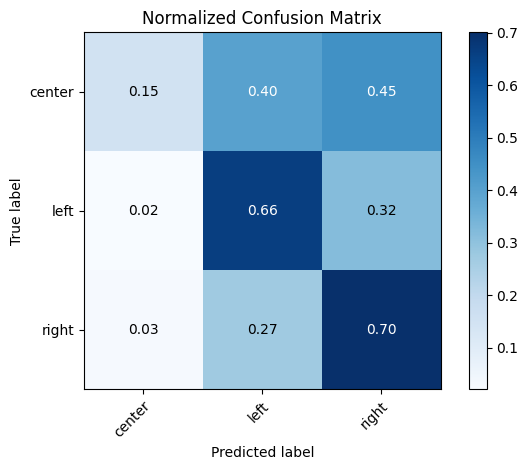

In [18]:
with open(f'bow_rf_{TARGET_COL}.pkl', 'rb') as file:
    bow_rf = pickle.load(file)
evaluate_clf(bow_rf, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)
del bow_rf

In [19]:
bow_xgb = xgb_finetuning(data_type)
with open(f'bow_xgb_{TARGET_COL}.pkl', 'wb') as file:
    pickle.dump(bow_xgb, file)

13 4


/home/egor/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:14:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


12 2
17 4
23 5
16 3


(10932,) (10932,)
              precision    recall  f1-score   support

           0       0.50      0.43      0.46      3572
           1       0.51      0.60      0.55      3655
           2       0.55      0.53      0.54      3705

    accuracy                           0.52     10932
   macro avg       0.52      0.52      0.52     10932
weighted avg       0.52      0.52      0.52     10932



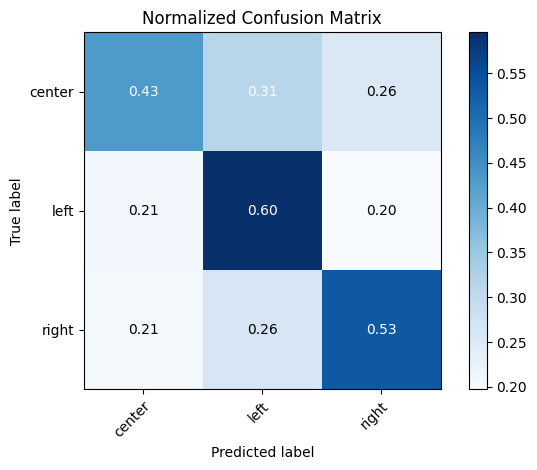

In [20]:
with open(f'bow_xgb_{TARGET_COL}.pkl', 'rb') as file:
    bow_xgb = pickle.load(file)
evaluate_clf(bow_xgb, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)
del bow_xgb

### Style SVM

In [21]:
data_type = 'style_bow'

In [22]:
clf_base_stylo = LinearSVC(max_iter=10 ** 3)
clf_base_stylo.fit(pipelines_data[data_type]['X_train'], pipelines_data[data_type]['y_train'])
with open(f'clf_base_stylo_{TARGET_COL}.pkl', 'wb') as file:
    pickle.dump(clf_base_stylo, file)

/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(10932,) (10932,)
              precision    recall  f1-score   support

           0       0.69      0.65      0.67      3572
           1       0.73      0.73      0.73      3655
           2       0.73      0.77      0.75      3705

    accuracy                           0.72     10932
   macro avg       0.72      0.72      0.72     10932
weighted avg       0.72      0.72      0.72     10932



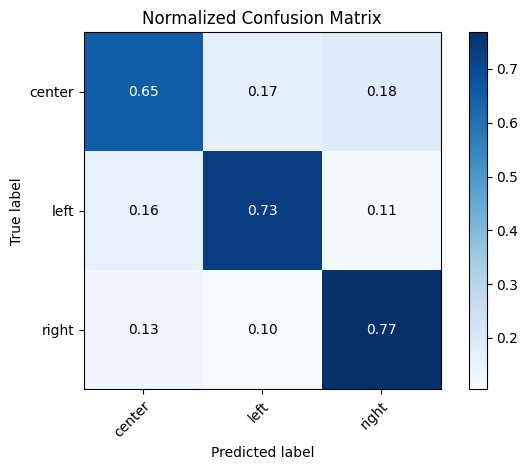

In [23]:
with open(f'clf_base_stylo_{TARGET_COL}.pkl', 'rb') as file:
    clf_base_stylo = pickle.load(file)
evaluate_clf(clf_base_stylo, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)
del clf_base_stylo

### Style + RF/XGB

In [24]:
style_rf = rf_finetuning(data_type)
with open(f'style_rf_{TARGET_COL}.pkl', 'wb') as file:
    pickle.dump(style_rf, file)

(10932,) (10932,)
              precision    recall  f1-score   support

           0       0.80      0.16      0.26      3572
           1       0.52      0.66      0.58      3655
           2       0.49      0.73      0.58      3705

    accuracy                           0.52     10932
   macro avg       0.60      0.52      0.47     10932
weighted avg       0.60      0.52      0.48     10932



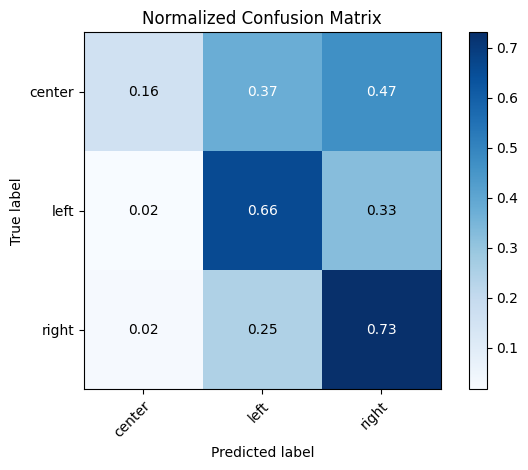

In [25]:
with open(f'style_rf_{TARGET_COL}.pkl', 'rb') as file:
    style_rf = pickle.load(file)
evaluate_clf(style_rf, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)
del style_rf

In [26]:
style_xgb = xgb_finetuning(data_type)
with open(f'style_xgb_{TARGET_COL}.pkl', 'wb') as file:
    pickle.dump(style_xgb, file)

15 3
11 5
13 5
22 4
16 3


(10932,) (10932,)
              precision    recall  f1-score   support

           0       0.53      0.47      0.50      3572
           1       0.57      0.61      0.59      3655
           2       0.58      0.61      0.59      3705

    accuracy                           0.56     10932
   macro avg       0.56      0.56      0.56     10932
weighted avg       0.56      0.56      0.56     10932



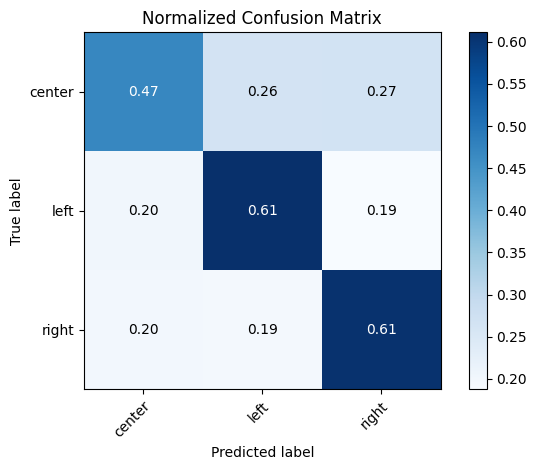

In [27]:
with open(f'style_xgb_{TARGET_COL}.pkl', 'rb') as file:
    style_xgb = pickle.load(file)
evaluate_clf(style_xgb, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)
del style_xgb